# N-band simulation of image source
This notebook is adapted from the SimMetis example notebook: https://github.com/astronomyk/SimMETIS/blob/master/notebooks/SimMETIS_simulate_image.ipynb

Each image is associated with a spectrum. The resulting `Source` object can be thought of as a cube, which is the sum of the images weighted with their associated spectrum. 

In [2]:
import numpy as np
from glob import glob
from astropy.io import fits

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import SimMETIS and check the versions of required packages:

In [3]:
import simmetis as sim
sim.bug_report()

Python:
 3.9.2 (default, Mar  3 2021, 11:58:52) 
[Clang 10.0.0 ]

simmetis :  0.3
astropy :  4.2.1
synphot :  1.0.1
numpy :  1.20.2
scipy :  1.6.2
poppy :  0.9.2
wget :  3.2

Operating system:  Darwin
         Release:  18.6.0
         Version:  Darwin Kernel Version 18.6.0: Thu Apr 25 23:16:27 PDT 2019; root:xnu-4903.261.4~2/RELEASE_X86_64
         Machine:  x86_64


The object will be observed in the N band. We start by setting up a `UserCommands` structure to configure SimMETIS to use the instrument setup or N-band imaging. If an L or M band observation is simulated, the LM config file needs to be uncommented.

In [13]:
cmds = sim.UserCommands('metis_image_N.config')
# cmds = sim.UserCommands("metis_image_LM.config")

## Setting up the source

In [4]:
with fits.open("image50au10_scat.fits") as inhdul:
    sourceimg = inhdul[0].data[0]
    sourcehdr = inhdul[0].header

try:
    print("Pixel unit:", sourcehdr['UNITS'])
except:
    print("Pixel unit:", sourcehdr['BUNIT'])

Pixel unit: Jy / pixel


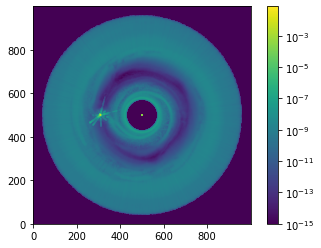

In [5]:
cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(sourceimg, cmap=cmap, norm=LogNorm(vmin=1e-15), origin='lower')
plt.colorbar()

In [6]:
# Check image pixel scale
try:
    pixscale = sourcehdr['CDELT1'] * -3600
except:
    pixscale = sourcehdr['CD1_1'] * -3600
print("Pixel scale:", pixscale, "arcsec/pixel")

Pixel scale: 0.00260003475982296 arcsec/pixel


If not been provided with a spectrum for this image, for simplicity assume a flat spectrum (in $f_{\lambda}$). 

As the image pixel values are in Jy/pixel and since SimMETIS operates internally with ph/(m2 s px bin), where bin is the spectral bin width, we need to calculate the conversion factor between the two. Here we compute the number of photons/(m2 s um) that correspond to 1 Jy at $\lambda_{\mathrm{ref}}$. This number is used to produce (internally) a cube. 

In [8]:
from astropy import units as u
lam_ref = 10 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                         equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

# SimMETIS expects the spectral flux density to be given in units of photons / (m2 s px bin):
dlam = 0.01  # [um], spectral bin width
lam = sim.utils.seq(10, 13.2, dlam)
flux = np.ones_like(lam) * flam_ref * dlam

1 Jy at 10.00 um corresponds to 1509190.18 ph / (m2 s um)


Alternatively, if a spectrum is provided:

In [14]:
# Read spectrum (function from radmc3dpy)
def readSpectrum(fname='', old=False):
    if fname.strip() == '':
        fname = 'spectrum.out'

    with open(fname, 'r') as rfile:
        # Read the format number
        dum = rfile.readline()
        # Read the number of wavelengths
        nwav = int(rfile.readline())
        # Read a blank line
        dum = rfile.readline()

        res = np.zeros([nwav, 2], dtype=np.float64)
        for iwav in range(nwav):
            dum = rfile.readline().split()
            res[iwav, 0] = float(dum[0])
            res[iwav, 1] = float(dum[1])

    return res

spectrum = readSpectrum("spectrum.out")
lam = spectrum[:,0]
spec = spectrum[:,1] * 1e23       # Conversion from erg s-1 cm-2 Hz-1 to Jy

dlam = lam[1]-lam[0]  # [um], spectral bin width
flux = np.ones_like(lam) * flam_ref * dlam

We can now construct the SimMETIS `Source` object using the function `sim.source.source_from_image`. The `oversample` parameter is necessary to prevent aliasing due to the way that images are currently handled in SimMETIS.

In [10]:
src = sim.source.source_from_image(sourceimg, lam, flux, 
                                   plate_scale=pixscale, oversample=4)

# Setting up and running the simulation

In [11]:
# List all available filters
filters = glob("../data/TC_filter*.dat")
#for filter in filters:
#    print(filter.split("/")[2])

In [14]:
# Set filter
cmds['INST_FILTER_TC'] = 'TC_filter_N2.dat'

# Build the optical train and the detector
opttrain = sim.OpticalTrain(cmds)
fpa = sim.Detector(cmds, small_fov=True)

# Apply optical train to source object
src.apply_optical_train(opttrain, fpa)

Safety switch is on - Detector(..., small_fov='True')
Generating image for chip 0


To create the simulated detector images we "read out" the detector with various exposure times (We could use `OBS_NDIT` to simulate a sequence of reads that would be averaged). The results are FITS HDU objects.

In [15]:
imghdu_1 = fpa.read_out(OBS_DIT=1)
imghdu_100 = fpa.read_out(OBS_DIT=100)
imghdu_7200 = fpa.read_out(OBS_DIT=7200)

Reading out chip 0 using superfast
DIT = 1    NDIT = 1.0
Reading out chip 0 using superfast
DIT = 100    NDIT = 1.0
Reading out chip 0 using superfast
DIT = 7200    NDIT = 1.0


In [213]:
imghdu_1.writeto("sd0615_METIS_N2_1sec.fits", overwrite=True)
imghdu_100.writeto("sd0615_METIS_N2_100sec.fits", overwrite=True)
imghdu_7200.writeto("sd0615_METIS_N2_7200sec.fits", overwrite=True)

## Looking at the results

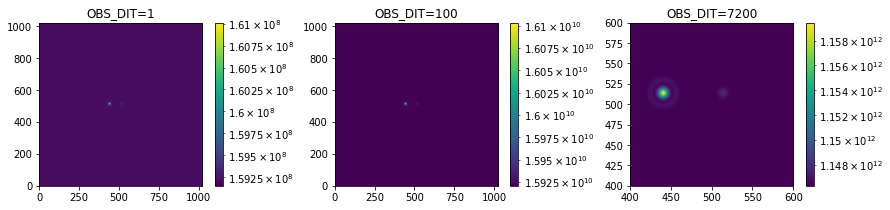

In [20]:
#extent = (xmin, xmax, ymin, ymax) = (900, 1150, 900, 1150)
extent = (xmin, xmax, ymin, ymax) = (400, 600, 400, 600)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

im1 = ax1.imshow(imghdu_1[0].data,
           norm=LogNorm(), origin='lower')
ax1.set_title("OBS_DIT=1")
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(imghdu_100[0].data, 
          norm=LogNorm(), origin='lower')
ax2.set_title("OBS_DIT=100")
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(imghdu_7200[0].data[xmin:xmax,ymin:ymax], extent=extent,
           norm=LogNorm(), origin='lower')
ax3.set_title("OBS_DIT=7200")
fig.colorbar(im3, ax=ax3)


In [212]:
print('pixel scale is', imghdu_100[0].header['CDELT1'] * 3600 * 1000, 'mas/pix')

pixel scale is 6.78999999999996 mas/pix


## Varying airmasses
The images above were simulated for airmass 1.0. We will now vary airmass at a fixed exposure time of 3600 s:

In [111]:
airmass = [1.0, 1.3, 2.0]

In [112]:
hdus_am = []
opttrains = []
for airm in airmass:
    print("Working on airmass", airm)
    cmds['ATMO_AIRMASS'] = airm
    opttrains.append(sim.OpticalTrain(cmds))
    fpa = sim.Detector(cmds, small_fov=False)
    src.apply_optical_train(opttrains[-1], fpa)
    hdus_am.append(fpa.read_out(OBS_DIT=3600.))
    hdus_am[-1].writeto("sd0615_METIS_N2_3600_" + str(airm) + ".fits", overwrite=True)

Working on airmass 1.0
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0
Working on airmass 1.3
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0
Working on airmass 2.0
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 3600.0    NDIT = 1.0


In [113]:
images_am = [hdu[0].data for hdu in hdus_am]
background_am = [np.mean(img[bgmask]) for img in images_am]
print("airmass   bg.counts")
for airm, bg in zip(airmass, background_am):
    print("{:.1f}      {:.5g}".format(airm, bg))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2048 but corresponding boolean dimension is 1024

In [26]:
src_am = [np.sum(img[srcmask] - bg) for img, bg in zip(images_am, background_am)]
print("airmass   src.counts")
for airm, ct in zip(airmass, src_am):
    print("{:.1f}        {:.4g}".format(airm, ct))

airmass   src.counts
1.0        9.189e+11
1.3        9.088e+11
2.0        8.857e+11


As expected, the number of background counts is increased as airmass increases while the number of source counts decreases. The latter only decreases slightly because the atmospheric transmission is relatively good in this filter.